In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import re
import nltk
nltk.download('stopwords')
import pandas as pd
import tqdm
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Load Data

In [5]:
train_df = pd.read_csv(r'gdrive/My Drive/Corona/Corona_NLP_train.csv', encoding='latin_1')
test_df = pd.read_csv(r'gdrive/My Drive/Corona/Corona_NLP_test.csv', encoding='latin_1')

In [6]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
train_df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [8]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [10]:
test_df.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [11]:
train_x, train_y = train_df['OriginalTweet'].copy(), train_df['Sentiment'].copy()

train_x.head()

0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
Name: OriginalTweet, dtype: object

In [12]:
test_x, test_y = test_df['OriginalTweet'].copy(), test_df['Sentiment'].copy()
test_x.head()

0    TRENDING: New Yorkers encounter empty supermar...
1    When I couldn't find hand sanitizer at Fred Me...
2    Find out how you can protect yourself and love...
3    #Panic buying hits #NewYork City as anxious sh...
4    #toiletpaper #dunnypaper #coronavirus #coronav...
Name: OriginalTweet, dtype: object

Data cleaning

In [15]:
stop = stopwords.words('english')
def clean(text):
        # specific
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
# menghapus url
#         text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'http\S+', '', text)
# menghapus @
    text = re.sub(r'@\w+', '', text)
# menghapus #
    text = re.sub(r'#\w+', '', text)
    
    text = re.sub(r'<.*?>', '', text)
        
    text = text.split()
        
    text = ' '.join([word.lower() for word in text if word.lower() not in stop])
        
    return text

In [16]:
train_x.head()
train_x_cleaned = train_x.apply(clean)
train_x_cleaned.head()

0                                                     
1    advice talk neighbours family exchange phone n...
2    coronavirus australia: woolworths give elderly...
3    food stock one empty... please, panic, enough ...
4    me, ready go supermarket outbreak. paranoid, f...
Name: OriginalTweet, dtype: object

In [17]:
test_x.head()
test_x_cleaned = test_x.apply(clean)
test_x_cleaned.head()

0    trending: new yorkers encounter empty supermar...
1    could find hand sanitizer fred meyer, turned ....
2                          find protect loved ones . ?
3    buying hits city anxious shoppers stock food&a...
4    one week everyone buying baby milk powder next...
Name: OriginalTweet, dtype: object

In [18]:
train_y.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [19]:
test_y.value_counts()

Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64

In [20]:
def pretrain(sentiment):
    if sentiment == "Positive":
        return 0
    
    elif sentiment == "Extremely Positive":
        return 0
    
    elif sentiment == "Negative":
        return 1
    
    elif sentiment == "Extremely Negative":
        return 1
    
    else:
        return 2
    
train_y = train_y.apply(pretrain)
train_y.value_counts(normalize= True)

0    0.438467
1    0.374128
2    0.187404
Name: Sentiment, dtype: float64

Tokenize

In [38]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(train_x_cleaned)
vocab_size = len

sekuens_train = tokenizer.texts_to_sequences(train_x_cleaned)

x = pad_sequences(sekuens_train)
print('example x:{}'.format(x[4]))

example x:[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0  314  649   23    7   65 3959    6
   29 1618  130  744  212   35   18 1605  354]


Model

In [39]:
BATCH_SIZE = 64
EPOCHS = 4
embedding_dim=16
model = Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [40]:
# Kompilasi Model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [41]:
# Melatih model menggunakan metode fit
history = model.fit(x, train_y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Epoch 1/4
515/515 [==============================] - 26s 46ms/step - loss: 1.0620 - accuracy: 0.4750 - val_loss: 0.5467 - val_accuracy: 0.7812
Epoch 2/4
515/515 [==============================] - 22s 43ms/step - loss: 0.4722 - accuracy: 0.8269 - val_loss: 0.4570 - val_accuracy: 0.8421
Epoch 3/4
515/515 [==============================] - 22s 43ms/step - loss: 0.3547 - accuracy: 0.8823 - val_loss: 0.4417 - val_accuracy: 0.8485
Epoch 4/4
515/515 [==============================] - 22s 43ms/step - loss: 0.3192 - accuracy: 0.8960 - val_loss: 0.4393 - val_accuracy: 0.8537


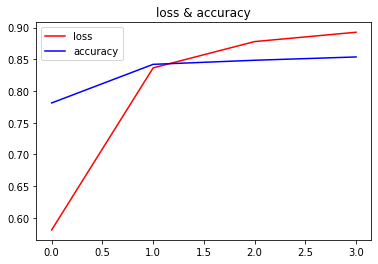

<Figure size 432x288 with 0 Axes>

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='loss ')
plt.plot(epochs, val_acc, 'b', label='accuracy')
plt.title('loss & accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()